<a href="https://colab.research.google.com/github/marioapn3/classification_star_galaxy_vgg16/blob/main/notebookeba338db9b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'stars-and-galaxies:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F865179%2F1479286%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T051210Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcbb1449c6d212df01b7e30fdfb97aa30d1962ece5e895a3df9889b109adcadcc533383ead5b3ece4240431af9abe7db481ed8d2a59fad2a58422ba5364aef6b53d85f691bb45b2e427c4243ff6c8294edcd50c1c09d49ba2773ae60954fc2215668a85beabc49b4483c456184ec6637bbaaf6d7af1fdb74f01cb5bb39c1b5ecad37daa2e1684e82b7a279eaeed5c7b3258510b2811f0fbe4cdb7f7b3bef612e1cc79601c571b84b7a7e4d5780e019975bbf115b35df398886576391d5c9c2f7b2f6a1a69e5441ee2c716d5c4f10bac9b390fd6fb03b6e7b8c39d5fce17fa7927a107bd0edc507dbfae7f323d18ece39bdbf7516fdc09ba1b4765da11d35a4307'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
direct = "../input/stars-and-galaxies/data"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential


2024-07-04 03:35:19.025018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 03:35:19.025134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 03:35:19.158025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Path to dataset
train_dir = f'{direct}/train'
val_dir =  f'{direct}/validation'

In [ ]:
# Image data generator
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
bs = 32
lr = 0.00
size = (224, 224)
shape = (224,224, 3)
epochs = 30
batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=size,
    batch_size=batch_size,
    class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_generator)

In [ ]:
image_batch = sample_training_images[:batch_size]

In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.VGG16(input_shape=shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)

In [ ]:
import tensorflow as tf

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
  base_model,

  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

# fit model
history = model.fit(train_generator,
                    epochs=30,
                    callbacks=[es],
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    )

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 565ms/step - accuracy: 0.5183 - loss: 0.6312 - val_accuracy: 0.5318 - val_loss: 0.6111
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 138s 539ms/step - accuracy: 0.5568 - loss: 0.5992 - val_accuracy: 0.3750 - val_loss: 0.5715
Epoch 3/30


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 518ms/step - accuracy: 0.5971 - loss: 0.5737 - val_accuracy: 0.5766 - val_loss: 0.5581
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 507ms/step - accuracy: 0.6339 - loss: 0.5467 - val_accuracy: 0.5625 - val_loss: 0.5443
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 527ms/step - accuracy: 0.6971 - loss: 0.5223 - val_accuracy: 0.6310 - val_loss: 0.5145
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 124s 481ms/step - accuracy: 0.7066 - loss: 0.5043 - val_accuracy: 0.8750 - val_loss: 0.4405
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 526ms/step - accuracy: 0.7512 - loss: 0.4843 - val_accuracy: 0.6925 - val_loss: 0.4783
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 478ms/step - accuracy: 0.7747 - loss: 0.4685 - val_accuracy: 0.9375 - val_loss: 0.3946
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 531ms/step - accuracy: 0.7839 - loss: 0.4514 - val_accuracy: 0.8488 - val_loss: 0.4480
Epoch 10/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 477ms/step - accuracy: 0.8054 - loss: 0.4

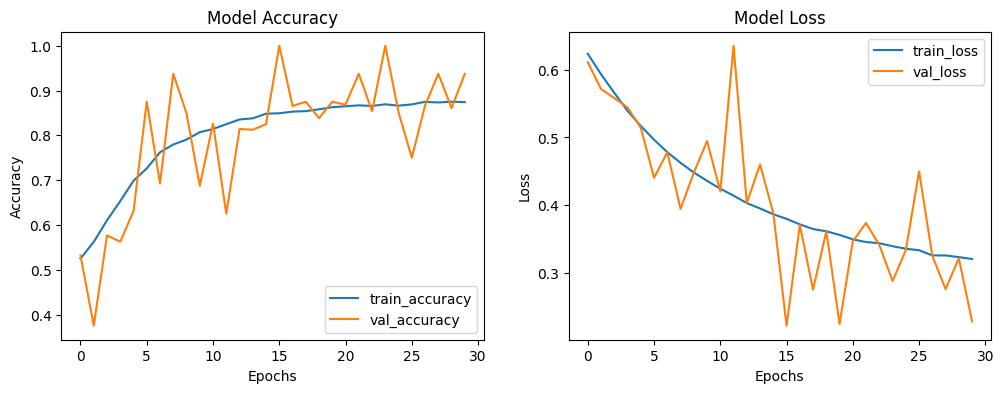

In [ ]:
# Plotting the model accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()